# Using deep neural networks to predict product color tags

Neural Networks can be used to identify the principal colors in an image. 

The present notebook uses the VCOR (vehicle color recognition) dataset to train a model for predicting color tags. The dataset has 15 color categories with on average 484 (min=210, max=742) images per category. I removed annotation errors from the training data.

Model performance on the validation and testset is quite good. To test if the model can tag non-vehicle images, I used a few images of the fashion product images (small) set, with promising results.

**Set seed**

In [1]:
import numpy as np
np.random.seed(345)
from tensorflow.random import set_seed
set_seed(3)

**Modules**

In [2]:
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn import datasets
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dropout,Flatten,Dense,Activation, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
tf.keras.backend.clear_session()
from tensorflow.keras.callbacks import CSVLogger
import time
from datetime import datetime

In [3]:
keras.__version__, tf.__version__

('2.6.0', '2.6.2')

**Set pathways**

In [4]:
train = '../input/vcor-vehicle-color-recognition-dataset/train/'
val = '../input/vcor-vehicle-color-recognition-dataset/val/'
test = '../input/vcor-vehicle-color-recognition-dataset/test/'
inference = '../input/fashion-product-images-small/images/'
annot_err = '../input/vcor-annot-errors/annotation-error.txt'

**Number of images per category**

The following shows that the number of images across color categories.

In [5]:
def count_images(dataset):
    """
    dataset: 'train/' or 'test/'
    """
    v = []
    for i in sorted(os.listdir(dataset)):
        v.append(len(os.listdir(dataset+i)))
    df = pd.DataFrame({'color': sorted(os.listdir(dataset)), 'count': v})
    return(df)

In [6]:
df = count_images(train)

In [7]:
df

,color,count
0,beige,421
1,black,406
2,blue,742
3,brown,565
4,gold,210
5,green,563
6,grey,428
7,orange,534
8,pink,483
9,purple,536


In [8]:
df['count'].min(), df['count'].mean(), df['count'].max()

(210, 484.46666666666664, 742)

In [9]:
df['count'].sum()

7267

In the following a list is created of the 15 color categories. The list will be sorted.

In [10]:
class_subset = sorted(os.listdir(train))

In [11]:
class_subset

['beige',
 'black',
 'blue',
 'brown',
 'gold',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'tan',
 'white',
 'yellow']

**Model parameters**

An EfficientNet will be used with weights from imagenet. No extensive parameter tuning was done so there is probably some room for performance improvement.  

In [12]:
isize = 224

In [13]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet',input_shape=(isize, isize, 3), pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(len(class_subset), activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

2022-08-26 13:46:57.947028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 13:46:58.053049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 13:46:58.053902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 13:46:58.055084: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

A number of data preprocessing and augmentations is done:
* rescale: normalizes pixel values between 0-1
* brightness range: specifies the range in which to decrease or increase brightness
* width_shift_range: shifts the width of the image 50%
* rotation_range: set to False.
* horizontal_flip: flips image horizontally
* vertical_flip: set to False.

In [15]:
train_generator = ImageDataGenerator(
    rescale=1/255.,              
    brightness_range=None,
    width_shift_range=0.5,
    rotation_range=False,
    horizontal_flip=True,
    vertical_flip=False    
)

valid_generator = ImageDataGenerator(rescale=1/255.)

In [16]:
test_generator = ImageDataGenerator(rescale=1./255)

Since the original dataset the image files are divided in different directories corresponding to each color, it is possible to use Keras `.flow_from_directory` method. However, since I removed image files that were incorrectly annotated, I decided to use `.flow_from_dataframe`. A function `dataframe_keras` creates a DataFrame with labels and directory names that is used as input.

In [17]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [18]:
def dataframe_keras(sourcedir, removal_files, textdir):
    """Automatically returns a DataFrame that can be used in flow_from_dataframe method.
    sourcedir: where the data folders corresponding to each class live, for ex. 'fashion-train/'
    The expected datastructure under sourcedir is for each class a folder with the corresponding image files.
    removal_files: indicate 'yes' if specific image files need to be removed, for instance because of annotation errors.
    textdir: directory where a textfile can be found with files to be removed.
    """
    
    coll_labelnames = []
    coll_idfiles = []

    for i in os.listdir(sourcedir):
        idfiles = os.listdir(os.path.join(sourcedir, i))
        
        labelnames = len(idfiles) * [str(i)]

        
        coll_labelnames.append(labelnames)
        coll_idfiles.append(idfiles)

    df = pd.DataFrame({'label': flatten(coll_labelnames), 'idfiles': flatten(coll_idfiles)})
    df['id'] = str(sourcedir) + df['label'] + '/' + df['idfiles']
    
    print('Raw data before removal has shape:', df.shape)
    
    # removes image files that are mentioned in textfile.
        
    if removal_files == 'yes':
        with open(textdir) as f:
            files_to_remove = f.read().splitlines()
        files_to_remove = list(filter(lambda x: 'jpg' in x, files_to_remove))
        print('Number of image files to be removed:', len(files_to_remove))
        df = df[~df['idfiles'].isin(files_to_remove)]
        print('Raw data after removal has shape:', df.shape)
    else:
        print('No images removed')
    
    return(df)

In [19]:
traindf = dataframe_keras(train, 'yes', annot_err)
validdf = dataframe_keras(val, 'yes', annot_err)

Raw data before removal has shape: (7267, 3)
Number of image files to be removed: 64
Raw data after removal has shape: (7202, 3)
Raw data before removal has shape: (1550, 3)
Number of image files to be removed: 64
Raw data after removal has shape: (1550, 3)


In [20]:
traindf.head()

,label,idfiles,id
0,orange,2cc754bf26.jpg,../input/vcor-vehicle-color-recognition-datase...
1,orange,a48677b1fe.jpg,../input/vcor-vehicle-color-recognition-datase...
2,orange,8b0bd6dd65.jpg,../input/vcor-vehicle-color-recognition-datase...
3,orange,bfe246fdb1.jpg,../input/vcor-vehicle-color-recognition-datase...
4,orange,f25641efb1.jpg,../input/vcor-vehicle-color-recognition-datase...


In [21]:
BATCH_SIZE = 16

In [22]:
traingen=train_generator.flow_from_dataframe(
    dataframe=traindf,
    directory=None,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(isize, isize))

validgen=valid_generator.flow_from_dataframe(
    dataframe=validdf,
    directory=None,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(isize, isize))

Found 7202 validated image filenames belonging to 15 classes.
Found 1550 validated image filenames belonging to 15 classes.


The `ModelCheckpoint` saves a Keras model after each epoch.
Early stopping is used to prevent overfitting and to ensure decreasing validation loss.


In [23]:
t1 = time.time()/60

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE
n_epochs = 80

csv_logger = CSVLogger('training.log', separator=',', append=False)

checkpointer = ModelCheckpoint(filepath='EFN-model.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, csv_logger],
                    verbose=True,
                    shuffle = True,
                    workers=4)

t2 = time.time()/60
print("Duration:", t2-t1)

2022-08-26 13:47:09.560068: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80


2022-08-26 13:47:24.356253: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


450/450 [==============================] - 160s 310ms/step - loss: 2.7022 - accuracy: 0.2402 - val_loss: 3.4101 - val_accuracy: 0.1087

Epoch 00001: val_loss improved from inf to 3.41009, saving model to EFN-model.best.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/80
450/450 [==============================] - 134s 297ms/step - loss: 1.5749 - accuracy: 0.5021 - val_loss: 1.1156 - val_accuracy: 0.6322

Epoch 00002: val_loss improved from 3.41009 to 1.11558, saving model to EFN-model.best.hdf5
Epoch 3/80
450/450 [==============================] - 135s 299ms/step - loss: 1.2454 - accuracy: 0.6040 - val_loss: 0.7698 - val_accuracy: 0.7344

Epoch 00003: val_loss improved from 1.11558 to 0.76978, saving model to EFN-model.best.hdf5
Epoch 4/80
450/450 [==============================] - 135s 299ms/step - loss: 1.0967 - accuracy: 0.6502 - val_loss: 0.6869 - val_accuracy: 0.7598

Epoch 00004: val_loss improved from 0.76978 to 0.68689, saving model to EFN-model.best.hdf5
Epoch 5/80
450/450 [==============================] - 136s 301ms/step - loss: 1.0041 - accuracy: 0.6738 - val_loss: 0.6491 - val_accuracy: 0.7637

Epoch 00005: val_loss improved from 0.68689 to 0.64909, saving model to EFN-model.best.hdf5
Epoch 6/80
450/450 [========================

In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


The following displays performance for train and validation data.

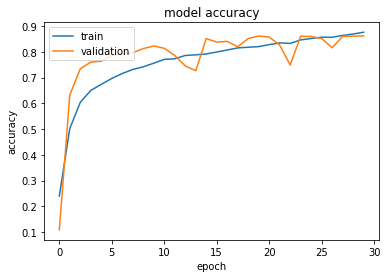

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Test performance**

Model performance is evaluated on an additional testset.

In [26]:
class_subset = sorted(os.listdir(test))

In [27]:
test_generator = ImageDataGenerator(rescale=1./255)

In [28]:
testgen = test_generator.flow_from_directory(test,
                                               target_size=(isize, isize),
                                               batch_size=1,
                                               class_mode=None,
                                               classes=class_subset,
                                               shuffle=False
                                               )

Found 1556 images belonging to 15 classes.


In [29]:
model_predict = model.predict(testgen)

In [30]:
model_predict.shape

(1556, 15)

In [31]:
df_testprediction = pd.DataFrame(model_predict, index=testgen.filenames, columns=class_subset)

In [32]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
df_testprediction

,beige,black,blue,brown,gold,green,grey,orange,pink,purple,red,silver,tan,white,yellow
beige/02e37c0e56.jpg,0.2319,0.0039,0.0020,0.0486,0.0013,0.0074,0.0767,0.0012,0.0010,0.0008,0.0164,0.1278,0.4628,0.0141,0.0041
beige/05aeb6ddec.jpg,0.5955,0.0034,0.0014,0.1957,0.0215,0.0036,0.0113,0.0011,0.0014,0.0014,0.0011,0.0050,0.1453,0.0112,0.0011
beige/0b01008bee.jpg,0.7144,0.0007,0.0023,0.0333,0.0212,0.0014,0.0029,0.0006,0.0033,0.0006,0.0011,0.0191,0.1734,0.0238,0.0021
beige/0c3bb456ee.jpg,0.4416,0.0030,0.0004,0.0065,0.0127,0.0023,0.0028,0.0027,0.0021,0.0014,0.0020,0.0355,0.4120,0.0641,0.0109
beige/0e491569c8.jpg,0.2705,0.0008,0.0004,0.0951,0.0020,0.0003,0.0174,0.0009,0.0080,0.0006,0.0010,0.0140,0.5874,0.0015,0.0003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yellow/fd1da2f797.jpg,0.0000,0.0000,0.0000,0.0000,0.0046,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.9950
yellow/fd3d2525fb.jpg,0.0002,0.0001,0.0002,0.0000,0.0008,0.0003,0.0000,0.0011,0.0042,0.0004,0.0001,0.0000,0.0004,0.0013,0.9910
yellow/feacf53e9e.jpg,0.0088,0.0007,0.0006,0.0006,0.0337,0.0187,0.0012,0.0001,0.0000,0.0015,0.0000,0.0016,0.0013,0.0004,0.9307
yellow/feeded3e6e.jpg,0.0002,0.0001,0.0000,0.0004,0.9515,0.0005,0.0004,0.0000,0.0000,0.0007,0.0000,0.0000,0.0000,0.0000,0.0460


In [33]:
predicted_classes = np.argmax(model.predict(testgen), axis=-1) #model.predict_classes(testgen). Argmax returns indices of max values
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

In [34]:
len(predicted_classes)

1556

The function `display_results` is used to display different performance metrics whereas `plot_predictions` allows to display image examples with prediction in title and true response in parentheses.  

In [35]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]), color=("green" if pred_idx == true_idx else "red"))
    fig.savefig('testgallery.png')

In [36]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 84.00%


,Precision,Recall,F-Score,Support
blue,0.9869,0.9497,0.9679,159.0000
green,0.9669,0.9669,0.9669,121.0000
purple,0.9573,0.9739,0.9655,115.0000
yellow,0.9664,0.9274,0.9465,124.0000
orange,0.9292,0.9211,0.9251,114.0000
red,0.8800,0.9706,0.9231,136.0000
pink,0.9888,0.8544,0.9167,103.0000
black,0.8495,0.9080,0.8778,87.0000
white,0.7900,0.9186,0.8495,86.0000
brown,0.8417,0.8347,0.8382,121.0000


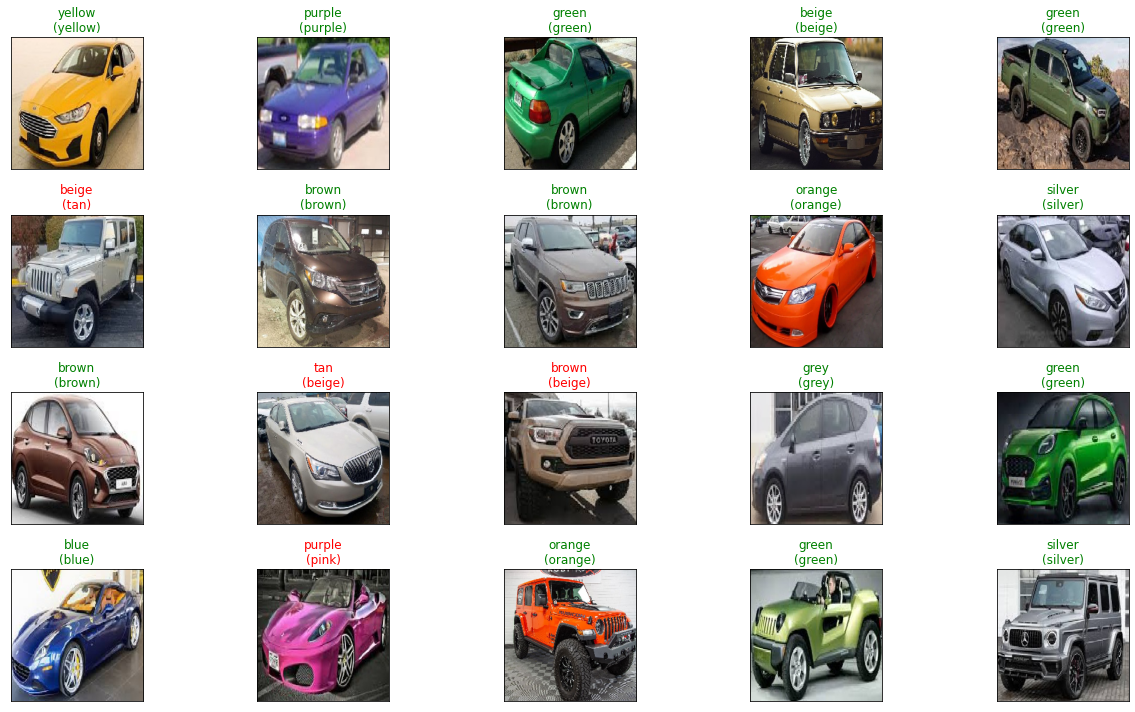

In [37]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

The confusion matrix shows that some labels have a substantial number of classification errors, such as beige and tan. 

In [38]:
pd.DataFrame(confusion_matrix(true_classes, predicted_classes), index=list(class_indices.values()), columns=list(class_indices.values()) )

,beige,black,blue,brown,gold,green,grey,orange,pink,purple,red,silver,tan,white,yellow
beige,45,1,0,4,1,0,1,0,0,0,0,1,35,2,0
black,0,79,0,2,0,0,6,0,0,0,0,0,0,0,0
blue,0,2,151,0,0,1,1,0,0,2,0,0,1,1,0
brown,7,2,0,101,4,0,2,1,0,0,0,1,3,0,0
gold,4,1,0,6,25,0,1,0,0,0,0,0,5,0,3
green,0,1,1,1,0,117,1,0,0,0,0,0,0,0,0
grey,0,7,0,3,0,1,66,0,0,0,0,13,0,2,0
orange,0,0,0,2,0,0,0,105,0,0,6,0,0,0,1
pink,0,0,0,0,0,0,0,0,88,3,12,0,0,0,0
purple,0,0,1,0,0,0,1,0,1,112,0,0,0,0,0


**Prediction of color for fashion products**

Let's test if the model could predict color tags for non-vehicle objects. Here are some examples of fashion products. The function `color_tag` enables to display the most probable tag(s) given a predetermined threshold.

In [39]:
def color_tag(sourcedir, imin, isize, thr):
    """
    Displays dominant colors beyond a given threshold.
    sourcedir: directory where image can be found, for ex.: '/home/administrateur/Documents/RR/colors/fashion-train/purple'
    imin : image input, for ex 'blue-car.jpg'
    isize: input image size, for ex. 224
    thr: chosen threshold value
    """
    
    image = tf.keras.preprocessing.image.load_img(os.path.join(sourcedir, imin), target_size=(isize, isize))
    data = asarray(image)
    ndata = np.expand_dims(data, axis=0)
    y_prob = model.predict(ndata/255)
    y_prob.argmax(axis=-1)
    
    print('color', [sorted(os.listdir(train))[i] for i in np.where(np.ravel(y_prob)>thr)[0]])
    print('values', [np.ravel(y_prob)[i] for i in list(np.where(np.ravel(y_prob)>thr)[0])])

*Example 1*

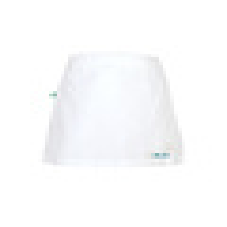

In [40]:
tf.keras.preprocessing.image.load_img(os.path.join(inference, '10000.jpg'), target_size=(227, 227))

In [41]:
color_tag(inference, '10000.jpg', isize, 0.1)

color ['black', 'brown', 'grey', 'purple']
values [0.2940117, 0.119148895, 0.19220358, 0.13615534]


*Example 2*

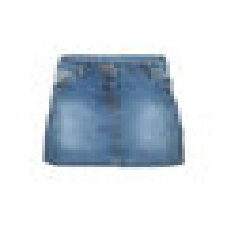

In [42]:
tf.keras.preprocessing.image.load_img(os.path.join(inference, '10001.jpg'), target_size=(227, 227))

In [43]:
color_tag(inference, '10001.jpg', isize, 0.1)

color ['black', 'grey', 'purple']
values [0.107998885, 0.10350288, 0.5977964]


*Example 3*

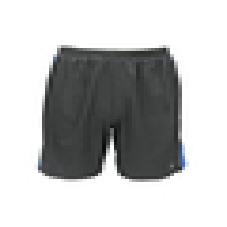

In [44]:
tf.keras.preprocessing.image.load_img(os.path.join(inference, '10004.jpg'), target_size=(227, 227))

In [45]:
color_tag(inference, '10004.jpg', isize, 0.1)

color ['black']
values [0.95571935]


*Example 4*

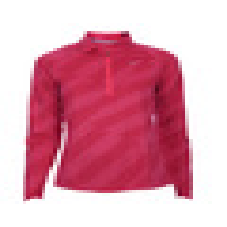

In [46]:
tf.keras.preprocessing.image.load_img(os.path.join(inference, '10025.jpg'), target_size=(227, 227))

In [47]:
color_tag(inference, '10025.jpg', isize, 0.1)

color ['pink']
values [0.575295]


*Example 5*

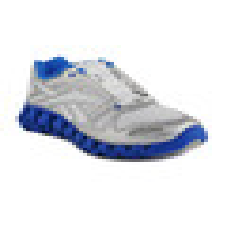

In [48]:
tf.keras.preprocessing.image.load_img(os.path.join(inference, '10081.jpg'), target_size=(227, 227))

In [49]:
color_tag(inference, '10081.jpg', isize, 0.1)

color ['black', 'grey']
values [0.26175585, 0.27550906]


Many of the predicted tags are quite correct. This is a promising result, though we it needs to be tested on an extensive sample. It shows that the model generalizes to non-vehicle samples, which is certainly we'd like to see for a color tagger.